In [2]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE, colors, etc.
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import numpy as np
import scipy as sp
import palettable
from sklearn.linear_model import LinearRegression

from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from collections import Counter

In [3]:
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/samfway/faculty_hiring/notebooks-productivity/figures/'

# Path to prepped DBLP pickles
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [4]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)  # This takes a minute..

# Helper Functions

In [5]:
# Find all current faculty at an instituion
def faculty_at_institution(institution_name):
    current_faculty = []
    for person in asst_faculty:
        if person.current_job()[0] == institution_name:
            current_faculty.append(person)
    return current_faculty

In [6]:
# Plot data with line of best fit
def plot_pubs_versus_prestige(data, ylabel):
    fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

    sorted_keys = sorted(data.keys())
    sorted_vals = [data[each] for each in sorted_keys]
    plt.plot(sorted_keys, sorted_vals, color=ACCENT_COLOR_1)

    regr = LinearRegression()
    regr.fit(np.array(sorted_keys).reshape(-1, 1), np.array(sorted_vals).reshape(-1, 1))
    x = np.array([min(sorted_keys), max(sorted_keys)])

    r2 = regr.score(np.array(sorted_keys).reshape(-1, 1), np.array(sorted_vals).reshape(-1, 1))
    print "Line of best fit has a slope of %.4f and a r^2 of %.4f" % (regr.coef_[0], r2)

    ax.plot(x, x*regr.coef_[0] + regr.intercept_, ':', color=ALMOST_BLACK)

    ax.set_xlabel('University Prestige')
    ax.set_ylabel(ylabel)

    finalize(ax)

    plt.show()

In [7]:
# Bin universities by prestige. Plot as a bar chart
def plot_binned_pubs_versus_prestige(data, ylabel, bins=10, type='bar'):
    fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

    sorted_keys = sorted(data.keys()); sorted_vals = [data[each] for each in sorted_keys]
    bin_means, bin_edges, binnumber = sp.stats.binned_statistic(sorted_keys, sorted_vals, bins = bins)
    if type == 'bar':
        plt.bar(np.linspace(0, 1, bins, endpoint=False), bin_means, width = 0.1, color=ACCENT_COLOR_1, edgecolor='w')
        
        small_diff = (bin_means[0] - bin_means[1])/bin_means[1]
        medium_diff = (bin_means[0] - np.average(bin_means[:int(bins/2)]))/np.average(bin_means[:int(bins/2)])
        large_diff = (bin_means[0] - np.average(bin_means[:bins]))/np.average(bin_means[:bins])
        print "Faculty at the top 10%% of schools have %.2f%%, %.2f%%, and %.2f%% more publications to their name than faculty at the top 20%%, 50%% and 100%% of schools." % (small_diff*100, medium_diff*100, large_diff*100) 
    elif type == 'line':
        plt.plot(np.linspace(0, 1, bins, endpoint=False), bin_means, color=ACCENT_COLOR_1)

        regr = LinearRegression()
        regr.fit(np.array(np.linspace(0, 1, bins, endpoint=False)).reshape(-1, 1), np.array(bin_means).reshape(-1, 1))
        x = np.array([0, 1])

        r2 = regr.score(np.array(np.linspace(0, 1, bins, endpoint=False)).reshape(-1, 1), np.array(bin_means).reshape(-1, 1))
        print "Line of best fit has a slope of %.4f and a r^2 of %.4f" % (regr.coef_[0], r2)

        ax.plot(x, x*regr.coef_[0] + regr.intercept_, ':', color=ALMOST_BLACK)
        
    ax.set_xlim(0, 1.0)
    ax.set_xlabel('Fractional University Prestige')
    ax.set_ylabel(ylabel)

    finalize(ax)
    
    plt.show()

In [8]:
def plot_pubs_versus_status(data, ylabel):
    fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

    sorted_keys = sorted(data.keys())
    sorted_vals = [data[each] for each in sorted_keys]

    plt.bar(sorted_keys, sorted_vals, color=ACCENT_COLOR_1, edgecolor='w')

    ax.set_xlabel('Public or Private Status')
    ax.set_ylabel(ylabel)

    ax.set_xticks(sorted_keys)
    ax.set_xticklabels(["public", "private"])

    finalize(ax)

    plt.show()

# Total Number of Publications

In [9]:
# Number of publications for all current assistant faculty of a university
pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name == "UNKNOWN" or name == 'All others':
        continue
    current_faculty = faculty_at_institution(name)
    n_pubs = [(person.facultyName, len(person.dblp_pubs)) for person in current_faculty if person.__contains__('dblp_pubs')]
    if len(n_pubs) > 0:
        pubs_by_inst[name] = n_pubs

### Prestige

In [10]:
# Average number of publications by university prestige
avg_pubs_by_prestige = {}; med_pubs_by_prestige = {}; std_pubs_by_prestige = {}
for (name, n_pubs) in pubs_by_inst.items():
    counts = [pubs for _, pubs in n_pubs]
    avg_pubs_by_prestige[inst[name]['pi']] = np.average(counts)
    med_pubs_by_prestige[inst[name]['pi']] = np.median(counts)
    std_pubs_by_prestige[inst[name]['pi']] = np.std(counts)

In [11]:
print("Std: Min: {0} Max: {1} Avg: {2}".format(min(std_pubs_by_prestige.values()), max(std_pubs_by_prestige.values()), np.average(std_pubs_by_prestige.values())))

Std: Min: 0.0 Max: 179.604160088 Avg: 48.6396652061


Line of best fit has a slope of -0.4180 and a r^2 of 0.3436


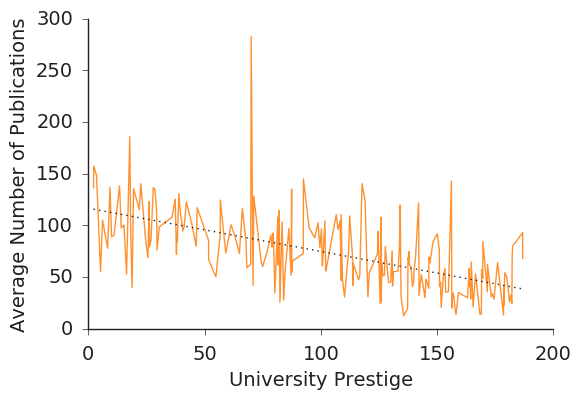

In [42]:
plot_pubs_versus_prestige(avg_pubs_by_prestige, 'Average Number of Publications')

In [13]:
# Who's this guy in the center? https://scholar.google.com/citations?user=HMnF6i0AAAAJ
[(name, pubs) for name, pubs in pubs_by_inst.items() if len(pubs) == 1 and pubs[0][1] == max(avg_pubs_by_prestige.values())]

[('CUNY Graduate Center', [('Robert Haralick', 283)])]

Faculty at the top 10% of schools have 5.75%, 14.02%, and 41.72% more publications to their name than faculty at the top 20%, 50% and 100% of schools.


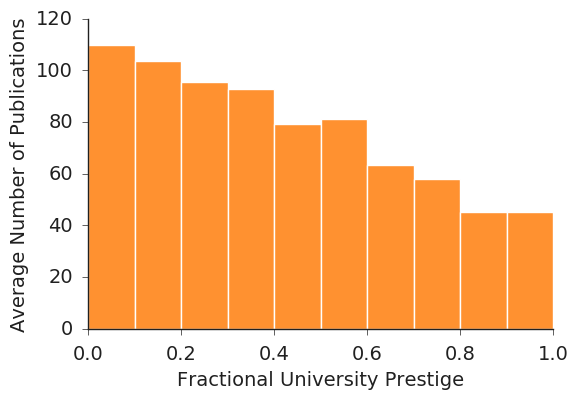

In [14]:
plot_binned_pubs_versus_prestige(avg_pubs_by_prestige, 'Average Number of Publications')

Line of best fit has a slope of -76.6941 and a r^2 of 0.9755


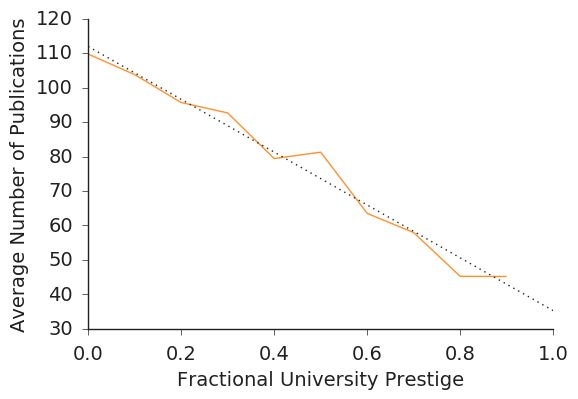

In [15]:
plot_binned_pubs_versus_prestige(avg_pubs_by_prestige, 'Average Number of Publications', type='line')

### Public/Private

In [16]:
# Average number of publications by public/private status
avg_pubs_by_status = {}; med_pubs_by_status = {}; std_pubs_by_status = {}
public = []; private = []
for (name, n_pubs) in pubs_by_inst.items():
    counts = [pubs for _, pubs in n_pubs]
    if inst[name]['private']:
        private.extend(counts)
    else:
        public.extend(counts)
        
avg_pubs_by_status[0] = np.average(public); avg_pubs_by_status[1] = np.average(private)
med_pubs_by_status[0] = np.median(public); med_pubs_by_status[1] = np.median(private)
std_pubs_by_status[0] = np.std(public); std_pubs_by_status[1] = np.std(private)

In [17]:
print("Avg: {0} Std: {1}".format(avg_pubs_by_status, std_pubs_by_status))

Avg: {0: 81.647577092511014, 1: 85.88928571428572} Std: {0: 72.040135233339825, 1: 74.994703809601091}


In [18]:
diff = 100*float(avg_pubs_by_status[1]-avg_pubs_by_status[0])/float(avg_pubs_by_status[0])
print "Faculty at private universities have %.2f%% more publications than faculty at public institutions" % diff

Faculty at private universities have 5.20% more publications than faculty at public institutions


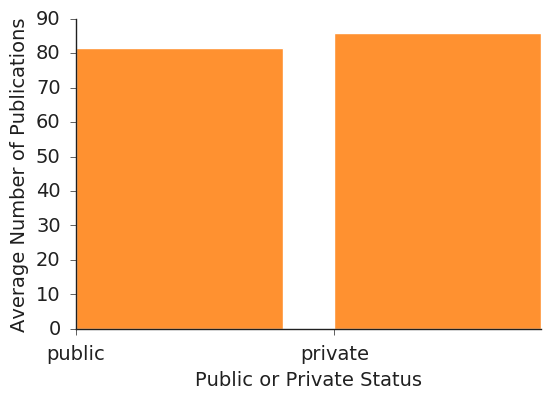

In [19]:
plot_pubs_versus_status(avg_pubs_by_status, 'Average Number of Publications')

# Fractional Contribution

In [20]:
# Fractional contribution of publications for all current assistant faculty of a university
frac_pubs_by_inst = {}

for (name, inst_data) in inst.items():
    if name == "UNKNOWN" or name == 'All others':
        continue
    current_faculty = faculty_at_institution(name)
    n_pubs = []
    for person in current_faculty:
        if person.__contains__('dblp_pubs'):
            frac_contribution = [1.0/float(len(pub['authors'])) for pub in person.dblp_pubs]
            n_pubs.append((person.facultyName, frac_contribution))
            
    if len(n_pubs) > 0:
        frac_pubs_by_inst[name] = n_pubs

In [21]:
# This is Aaron:
#frac_pubs_by_inst['University of Colorado, Boulder'][4]

### Prestige

In [22]:
# Average fractional contribution by university prestige
avg_frac_pubs_by_prestige = {}; med_frac_pubs_by_prestige = {}; std_frac_pubs_by_prestige = {}
for (name, n_pubs) in frac_pubs_by_inst.items():
    counts = []
    for _, frac_contribution in n_pubs:
        counts.extend(frac_contribution)
        
    avg_frac_pubs_by_prestige[inst[name]['pi']] = np.average(counts)
    med_frac_pubs_by_prestige[inst[name]['pi']] = np.median(counts)
    std_frac_pubs_by_prestige[inst[name]['pi']] = np.std(counts)

In [23]:
print("Std: Min: {0} Max: {1} Avg: {2}".format(min(std_frac_pubs_by_prestige.values()), max(std_frac_pubs_by_prestige.values()), np.average(std_frac_pubs_by_prestige.values())))

Std: Min: 0.05 Max: 0.288227085725 Avg: 0.199015990358


Line of best fit has a slope of 0.0001 and a r^2 of 0.0107


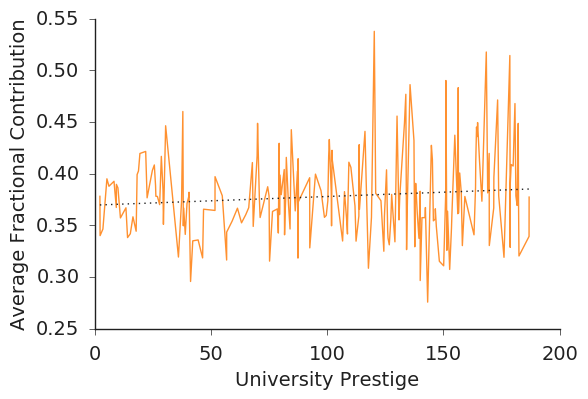

In [24]:
plot_pubs_versus_prestige(avg_frac_pubs_by_prestige, 'Average Fractional Contribution')

Line of best fit has a slope of 0.0180 and a r^2 of 0.2507


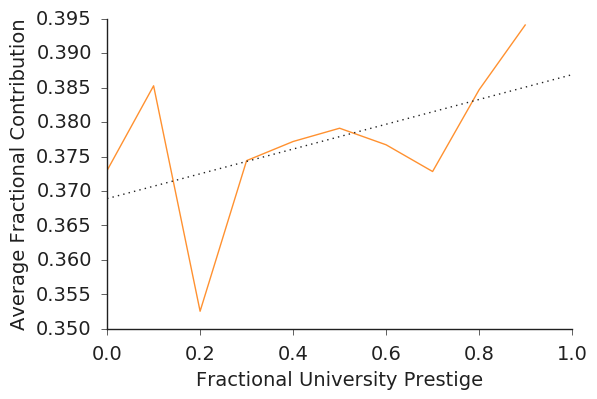

In [25]:
plot_binned_pubs_versus_prestige(avg_frac_pubs_by_prestige, 'Average Fractional Contribution', type='line')

### Public/Private

In [26]:
# Average number of publications by public/private status
avg_frac_pubs_by_status = {}; med_frac_pubs_by_status = {}; std_frac_pubs_by_status = {}
public = []; private = []
for (name, n_pubs) in frac_pubs_by_inst.items():
    counts = []
    for _, frac_contribution in n_pubs:
        counts.extend(frac_contribution)
        
    if inst[name]['private']:
        private.extend(counts)
    else:
        public.extend(counts)
        
avg_frac_pubs_by_status[0] = np.average(public); avg_frac_pubs_by_status[1] = np.average(private)
med_frac_pubs_by_status[0] = np.median(public); med_frac_pubs_by_status[1] = np.median(private)
std_frac_pubs_by_status[0] = np.std(public); std_frac_pubs_by_status[1] = np.std(private)

In [27]:
print("Avg: {0} Std: {1}".format(avg_frac_pubs_by_status, std_frac_pubs_by_status))

Avg: {0: 0.3685724827164476, 1: 0.37650548732152217} Std: {0: 0.19992825908145978, 1: 0.21445825749191594}


In [28]:
diff = 100*float(avg_frac_pubs_by_status[1] - avg_frac_pubs_by_status[0])/float(avg_frac_pubs_by_status[0])
print "Faculty at private universities have %.2f%% higher contribution to papers than faculty at public institutions" % diff

Faculty at private universities have 2.15% higher contribution to papers than faculty at public institutions


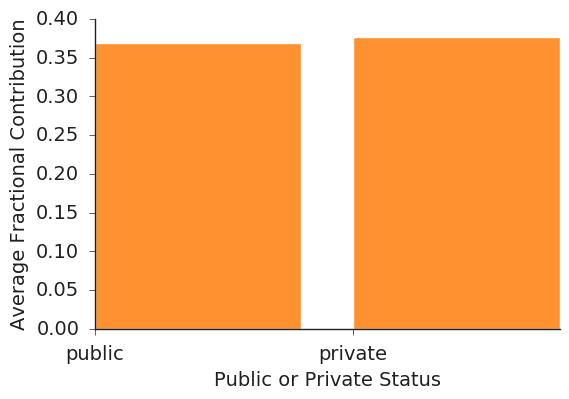

In [29]:
plot_pubs_versus_status(avg_frac_pubs_by_status, 'Average Fractional Contribution')

# Exclude Middle Author Role From Number of Publications

In [30]:
# Number of publications for all current assistant faculty of a university
first_and_last_pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name == "UNKNOWN" or name == 'All others':
        continue
    current_faculty = faculty_at_institution(name)
    
    n_pubs = []
    for person in current_faculty:
        if person.__contains__('dblp_pubs'):
            first_and_last_contributions = [pub for pub in person.dblp_pubs if pub['author_role'] != 1]
            n_pubs.append((person.facultyName, len(first_and_last_contributions)))
    if len(n_pubs) > 0:
        first_and_last_pubs_by_inst[name] = n_pubs

In [41]:
# This is also Aaron:
#print first_and_last_pubs_by_inst['University of Colorado, Boulder'][4]
#print pubs_by_inst['University of Colorado, Boulder'][4]

### Prestige

In [32]:
avg_first_last_pubs_by_prestige = {}; med_first_last_pubs_by_prestige = {}; std_first_last_pubs_by_prestige = {}
for (name, n_pubs) in first_and_last_pubs_by_inst.items():
    counts = [pubs for _, pubs in n_pubs]
    avg_first_last_pubs_by_prestige[inst[name]['pi']] = np.average(counts)
    med_first_last_pubs_by_prestige[inst[name]['pi']] = np.median(counts)
    std_first_last_pubs_by_prestige[inst[name]['pi']] = np.std(counts)

In [33]:
print("Std: Min: {0} Max: {1} Avg: {2}".format(min(std_pubs_by_prestige.values()), max(std_pubs_by_prestige.values()), np.average(std_pubs_by_prestige.values())))

Std: Min: 0.0 Max: 179.604160088 Avg: 48.6396652061


Line of best fit has a slope of -0.2978 and a r^2 of 0.3545


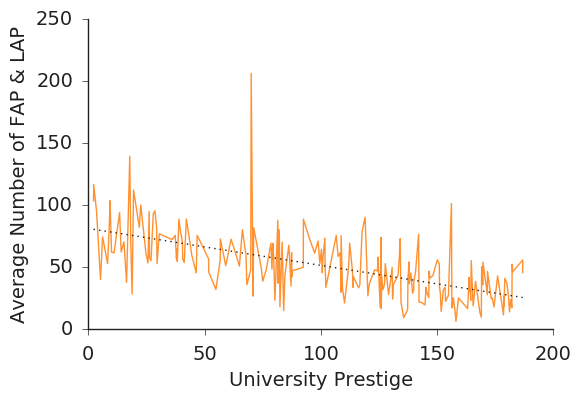

In [34]:
plot_pubs_versus_prestige(avg_first_last_pubs_by_prestige, 'Average Number of FAP & LAP')

Faculty at the top 10% of schools have 7.91%, 18.92%, and 48.85% more publications to their name than faculty at the top 20%, 50% and 100% of schools.


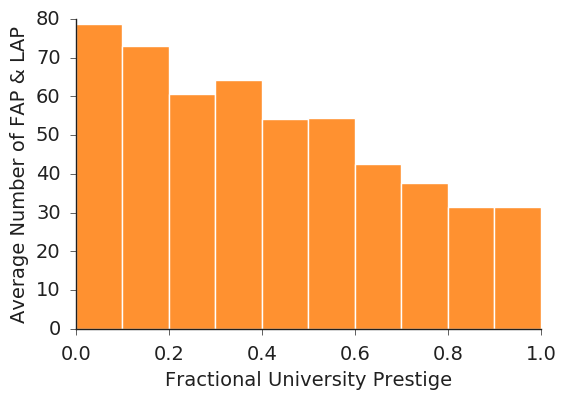

In [35]:
plot_binned_pubs_versus_prestige(avg_first_last_pubs_by_prestige, 'Average Number of FAP & LAP')

Line of best fit has a slope of -54.1751 and a r^2 of 0.9641


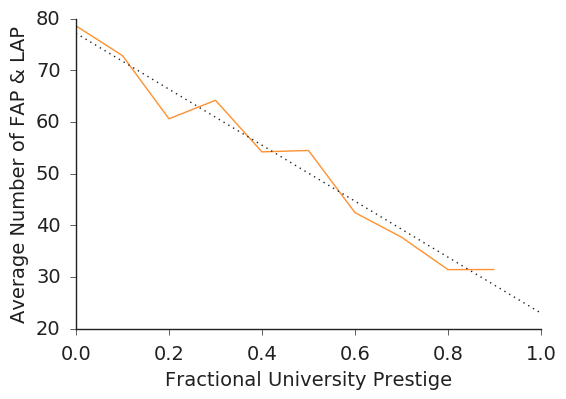

In [36]:
plot_binned_pubs_versus_prestige(avg_first_last_pubs_by_prestige, 'Average Number of FAP & LAP', type='line')

### Public vs Private

In [37]:
# Average number of publications by public/private status
avg_first_last_pubs_by_status = {}; med_first_last_pubs_by_status = {}; std_first_last_pubs_by_status = {}
public = []; private = []
for (name, n_pubs) in first_and_last_pubs_by_inst.items():
    counts = [pubs for _, pubs in n_pubs]
        
    if inst[name]['private']:
        private.extend(counts)
    else:
        public.extend(counts)
        
avg_first_last_pubs_by_status[0] = np.average(public); avg_first_last_pubs_by_status[1] = np.average(private)
med_first_last_pubs_by_status[0] = np.median(public); med_first_last_pubs_by_status[1] = np.median(private)
std_first_last_pubs_by_status[0] = np.std(public); std_first_last_pubs_by_status[1] = np.std(private)

In [38]:
print("Avg: {0} Std: {1}".format(avg_frac_pubs_by_status, std_frac_pubs_by_status))

Avg: {0: 0.3685724827164476, 1: 0.37650548732152217} Std: {0: 0.19992825908145978, 1: 0.21445825749191594}


In [39]:
diff = 100*float(avg_first_last_pubs_by_status[1] - avg_first_last_pubs_by_status[0])/float(avg_first_last_pubs_by_status[0])
print "Faculty at public universities have %.2f%% more first and last author papers than faculty at private institutions" % diff

Faculty at public universities have 7.28% more first and last author papers than faculty at private institutions


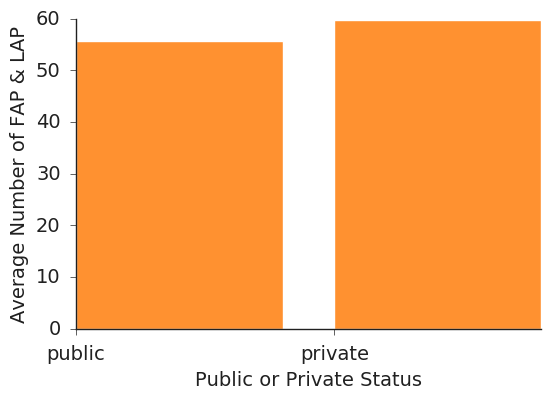

In [40]:
plot_pubs_versus_status(avg_first_last_pubs_by_status, 'Average Number of FAP & LAP')